# TELCO CUSTOMER CHURN MODEL DEVELOPMENT

In [1]:
#import libraries used during model development
from explore import wrangle, perform_eda #module to wrangle the dataset

import shap
import pandas as pd
import seaborn as sns
from math import ceil
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier

c:\Users\solace.dark\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import & Clean Telco Customer Churn Dataset

In [2]:
#prepare the dataset
data = wrangle('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

#assert if the dataset has the expected characteristics
assert ((len(data) == 7043) & (len(data.columns) == 20)), f'The dataset does not contain the expected characteristics'

c:\Users\solace.dark\Documents\Jupyter Notebook\Projects\churn_prediction\explore.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})


In [7]:
#save cleaned dataset
joblib.dump(data, 'dataset.pkl')

['dataset.pkl']

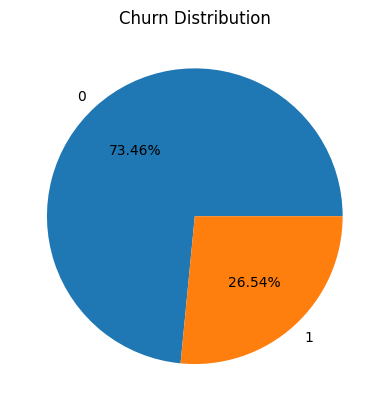

In the last month, 73.46% of customers continue to use the telco services. 26.54% of customers churned.

The data is imbalanced. "0" is 73.46% of the data. And "1" is 26.54% of the data.


In [17]:
#get value counts for Churn values
churn_values = data['Churn'].value_counts(normalize=True)

#return churn distribution
perform_eda(df=data, columns='Churn')

if (churn_values.iloc[0] != churn_values.iloc[1]) | (churn_values.iloc[0] >= 1.5*churn_values.iloc[1]) | (churn_values.iloc[1] >= 1.5*churn_values.iloc[0]):
    print(f'\nThe data is imbalanced. "{churn_values.index[0]}" is {round(churn_values.iloc[0]*100, 2)}% of the data. And "{churn_values.index[1]}" is {round(churn_values.iloc[1]*100, 2)}% of the data.')

During model development, a few models will be trained on the dataset. And the best performing model will be selected. Logistic Regression will be trained initially as the baseline model. Then a Random  Forest Classifier, Catboost Classifier and Explainable Boosting Machine.

The model that will be selected will have to beat the baseline model and all the other models. This selected model can be deployed and monitored

# Models Training

### 1. Baseline Model: LogisticRegression

In [3]:
#make copy of dataset
df = data.copy()

#extract indexes of features for preprocessing
category_features = [i for i, col in enumerate(df.columns) if col in df.select_dtypes('object').columns]
numeric_features =  [i for i, col in enumerate(df.columns) if col in df.select_dtypes('number').columns and col != 'Churn']

In [20]:
#build preprocessing pipeline
numeric_transformer = Pipeline(steps=[('standardscaler', StandardScaler())
                                     ])
category_transformer = Pipeline(steps=[('ordinalencoder', OrdinalEncoder())
                                      ])                                      
preprocessor = ColumnTransformer(transformers=[
    ('numeric_transform', numeric_transformer, numeric_features),
    ('category_transform', category_transformer, category_features)
])

#return preprocessor pipeline
preprocessor

ColumnTransformer(transformers=[('numeric_transform',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 [4, 17, 18, 19]),
                                ('category_transform',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                  15, 16])])

In [21]:
#build pipeline for logistic regression model and the preprocessor
reg_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logisticregression', LogisticRegression(max_iter=10_000, class_weight='balanced'))
])

#return classifier pipeline
reg_classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transform',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  [4, 17, 18, 19]),
                                                 ('category_transform',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 2, 3, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15,
                                                   16])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=10000))])

In [8]:
#split dataset
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, stratify=y, random_state=42
)

In [23]:
#save the train and test sets
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(y_train, 'y_train.pkl')
joblib.dump(X_test, 'X_test.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']

In [6]:
#this code times how long the models take to train. It will be used to time the models to be trained next.
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i:%i:%i' % (thour, tmin, round(tsec, 2)))

In [ ]:
#range of hyperparameter values for fine-tuning logistic regression
reg_params = {'logisticregression__C': [.001, .01, 1, 10, 100]}

#instantiate randomized search
reg_randomSearch = RandomizedSearchCV(reg_classifier,
                                   param_distributions=reg_params,
                                   cv=5,
                                   verbose=1,
                                   n_iter=5,
                                   random_state=42)

start_time = timer(None) #timer start point

#train model on the train set
reg_randomSearch.fit(X_train, y_train)

timer(start_time) #execute timer

In [ ]:
#return the best rank score from randomized search results
reg_results = pd.DataFrame(reg_randomSearch.cv_results_)
reg_results[reg_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.058766,0.001938,0.016991,0.00219,1.0,{'logisticregression__C': 1},0.766637,0.760426,0.759539,0.736469,0.714032,0.74742,0.019596,1


In [ ]:
#return the parameter for the best model
reg_best_param = reg_randomSearch.best_params_
reg_best_param

{'logisticregression__C': 1}

In [ ]:
#get the best performing model
reg_best_model = reg_randomSearch.best_estimator_

#return accuracy score of logistic regression best model
reg_accuracy = reg_best_model.score(X_test, y_test)
print(f'Accuracy of logistic regression: {round(reg_accuracy * 1e2, 2)}%')

Accuracy of logistic regression: 73.81%


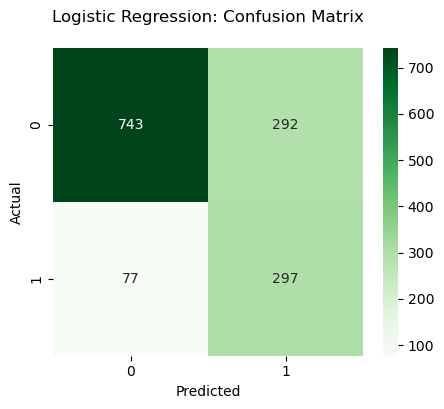

In [ ]:
#serve predictions
reg_y_predict = reg_best_model.predict(X_test)

#evaluate best model with confusion matrix
reg_confusion = confusion_matrix(y_test, reg_y_predict)

plt.figure(figsize=(5,4))
sns.heatmap(reg_confusion, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression: Confusion Matrix\n')
plt.show()

In [ ]:
# Evaluate Logistic Regression performance metrics
reg_precision = precision_score(y_test, reg_y_predict, pos_label=1)
reg_recall = recall_score(y_test, reg_y_predict, pos_label=1)
reg_f1 = f1_score(y_test, reg_y_predict, pos_label=1)

print(f'Logistic regression model yielded {round(reg_accuracy * 1e2, 1)}% accuracy.\nThis is the proportion of correctly predicted churn cases out of all cases.')
print(f'\nThe precision score is {round(reg_precision * 1e2, 1)}%. This is the proportion of churn cases that are actually customers who churned.')
print(f'\nThe recall score is {round(reg_recall * 1e2, 1)}%. This is the proportion of churn cases correctly predicted as customers who churned.')
print(f'\nThe f1-score is {round(reg_f1 * 1e2, 1)}%. This is the balance between the precision \nand recall scores.')

Logistic regression model yielded 73.8% accuracy.
This is the proportion of correctly predicted churn cases out of all cases.

The precision score is 50.4%. This is the proportion of churn cases that are actually customers who churned.

The recall score is 79.4%. This is the proportion of churn cases correctly predicted as customers who churned.

The f1-score is 61.7%. This is the balance between the precision 
and recall scores.


In [ ]:
#get prediction prababilities for churn cases (positive class)
reg_y_predict_proba = reg_best_model.predict_proba(X_test)[:, 1]

#return AUC score for the Logistic Regression ROC curve
reg_auc = roc_auc_score(y_test, reg_y_predict_proba)
print(f'AUC score for Logistic Regression model: {round(reg_auc*1e2, 1)}%')

AUC score for Logistic Regression model: 84.0%


### 2. Random Forests

The preprocessor pipeline and dataset split has already been performed in previous model.
They will be employed here to train a random forest classifier

In [84]:
#build pipeline for Random Forest model and the preprocessor
rf_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('randomforest', RandomForestClassifier(class_weight='balanced', random_state=42))
])

#run classifier pipeline output
rf_classifier

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_transform',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  [4, 17, 18, 19]),
                                                 ('category_transform',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  [0, 1, 2, 3, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15,
                                                   16])])),
                ('randomforest',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [ ]:
#parameters for fine-tuning Random Forest
rf_params = {'randomforest__n_estimators': range(100, 301, 50),
          'randomforest__max_depth': range(5, 21, 5),
          'randomforest__max_features': range(3, 5)}

#instantiate random search
rf_randomSearch = RandomizedSearchCV(rf_classifier,
                                   param_distributions=rf_params,
                                   cv=5,
                                   verbose=1,
                                  random_state=42)

start_time = timer(None) #timer start point

#train model on the training set
rf_randomSearch.fit(X_train, y_train)

timer(start_time) #execute timer

Fitting 5 folds for each of 10 candidates, totalling 50 fits

 Time taken: 0:1:8


In [ ]:
#return the parameter for the best model
rf_randomSearch.best_params_

{'randomforest__n_estimators': 150,
 'randomforest__max_features': 4,
 'randomforest__max_depth': 15}

In [ ]:
#get random forest best model
rf_best_model = rf_randomSearch.best_estimator_

#return accuracy score of Random Forest best model
rf_accuracy = rf_best_model.score(X_test, y_test)
print(f'Accuracy of Random Forest best_model: {round(rf_accuracy*1e2, 2)}%')

Accuracy of Random Forest best_model: 79.49%


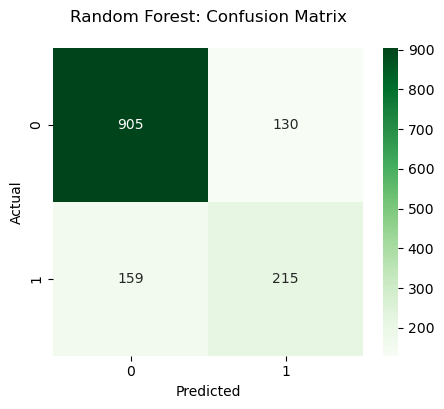

In [ ]:
#serve predictions
rf_y_predict = rf_best_model.predict(X_test)

#evaluate best model with confusion matrix
rf_confusion = confusion_matrix(y_test, rf_y_predict)

plt.figure(figsize=(5,4))
sns.heatmap(rf_confusion, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest: Confusion Matrix\n')
plt.show()

In [ ]:
# Evaluate Random Forest performance metrics
rf_precision = precision_score(y_test, rf_y_predict, pos_label=1)
rf_recall = recall_score(y_test, rf_y_predict, pos_label=1)
rf_f1 = f1_score(y_test, rf_y_predict, pos_label=1)

print(f'Random forest model yielded {round(rf_accuracy * 1e2, 2)}% accuracy.\nThis is the proportion of correctly predicted churn cases out of all cases.')
print(f'\nThe precision score is {round(rf_precision * 1e2, 2)}%. This is the proportion of churn cases that are actually customers who churned.')
print(f'\nThe recall score is {round(rf_recall * 1e2, 2)}%. This is the proportion of churn cases correctly predicted as customers who churned.')
print(f'\nThe f1-score is {round(rf_f1 * 1e2, 2)}%. This is the balance between the precision and recall scores.')

Random forest model yielded 79.49% accuracy.
This is the proportion of correctly predicted churn cases out of all cases.

The precision score is 62.32%. This is the proportion of churn cases that are actually customers who churned.

The recall score is 57.49%. This is the proportion of churn cases correctly predicted as customers who churned.

The f1-score is 59.81%. This is the balance between the precision and recall scores.


In [ ]:
#get prediction probabilities for churn cases (positive class)
rf_y_predict_proba = rf_best_model.predict_proba(X_test)[:, 1]

#return AUC score for the Random Forest ROC curve
rf_auc = roc_auc_score(y_test, rf_y_predict_proba)
print(f'AUC score for Random Forest: {round(rf_auc*1e2, 1)}%')

AUC score for Random Forest: 83.0%


### 3. Catboost Classifier

In [4]:
#instantiate catboost classifier
cat_classifier = CatBoostClassifier(cat_features=category_features, scale_pos_weight=3, random_state=42)

In [9]:
#range of hyperparameter values for fine-tuning catboost
cat_params = {'iterations': range(100, 201, 50),
              'learning_rate': [.01, .03, .05, .07],
              'depth': range(5, 9)}

#instantiate randomizedsearchcv
cat_randomSearch = RandomizedSearchCV(cat_classifier,
                                   param_distributions=cat_params,
                                   cv=5,
                                   verbose=1,
                                   random_state=42)

start_time = timer(None) #timer start point

#train model on the train set
cat_randomSearch.fit(X_train, y_train)

timer(start_time) #execute timer

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.6760208	total: 209ms	remaining: 20.6s
1:	learn: 0.6608411	total: 235ms	remaining: 11.5s
2:	learn: 0.6449872	total: 261ms	remaining: 8.44s
3:	learn: 0.6320583	total: 285ms	remaining: 6.84s
4:	learn: 0.6189175	total: 304ms	remaining: 5.78s
5:	learn: 0.6079893	total: 328ms	remaining: 5.14s
6:	learn: 0.5971023	total: 360ms	remaining: 4.79s
7:	learn: 0.5883962	total: 385ms	remaining: 4.42s
8:	learn: 0.5799536	total: 412ms	remaining: 4.17s
9:	learn: 0.5720132	total: 444ms	remaining: 3.99s
10:	learn: 0.5648059	total: 471ms	remaining: 3.81s
11:	learn: 0.5589653	total: 495ms	remaining: 3.63s
12:	learn: 0.5527740	total: 522ms	remaining: 3.49s
13:	learn: 0.5476956	total: 547ms	remaining: 3.36s
14:	learn: 0.5431623	total: 568ms	remaining: 3.22s
15:	learn: 0.5396436	total: 590ms	remaining: 3.1s
16:	learn: 0.5352599	total: 611ms	remaining: 2.98s
17:	learn: 0.5304985	total: 636ms	remaining: 2.9s
18:	learn: 0.5269034	total: 665ms

In [ ]:
#make dataframe for the results and return best ranking score 
cat_result = pd.DataFrame(cat_randomSearch.cv_results_)
cat_result[cat_result['rank_test_score']==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_iterations,param_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,4.835236,0.291784,0.01859,0.006016,0.07,150,8,"{'learning_rate': 0.07, 'iterations': 150, 'de...",0.759539,0.772848,0.754215,0.748891,0.720249,0.751148,0.017381,1


In [69]:
#parameters that yielded best score
cat_randomSearch.best_params_

{'learning_rate': 0.07, 'iterations': 150, 'depth': 8}

In [10]:
#assign the best model to a variable
cat_best_model = cat_randomSearch.best_estimator_

#return accuracy score of catboost best model
cat_accuracy = cat_best_model.score(X_test, y_test)
print(f'Accuracy of Catboost best_model: {round(cat_accuracy*1e2, 2)}%')

Accuracy of Catboost best_model: 74.95%


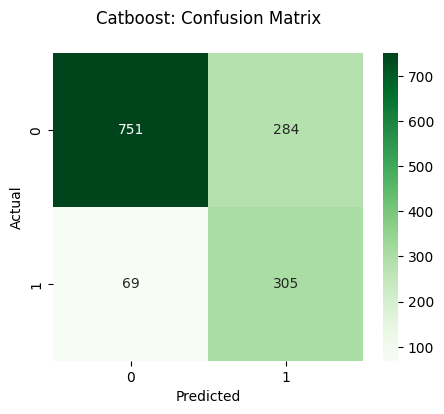

In [71]:
#serve predictions
cat_y_predict = cat_best_model.predict(X_test)

#evaluate best model with confusion matrix plot
cat_confusion = confusion_matrix(y_test, cat_y_predict)

plt.figure(figsize=(5,4))
sns.heatmap(cat_confusion, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Catboost: Confusion Matrix\n')
plt.show()

In [ ]:
# Evaluate performance metrics
cat_precision = precision_score(y_test, cat_y_predict, pos_label=1)
cat_recall = recall_score(y_test, cat_y_predict, pos_label=1)
cat_f1 = f1_score(y_test, cat_y_predict, pos_label=1)

print(f'Catboost model yielded {round(cat_accuracy * 1e2, 1)}% accuracy.\nThis is the proportion of correctly predicted churn cases out of all cases.')
print(f'\nThe precision score is {round(cat_precision * 1e2, 1)}%. This is the proportion of churn cases that are actually customers who churned.')
print(f'\nThe recall score is {round(cat_recall * 1e2, 1)}%. This is the proportion of churn cases correctly predicted as customers who churned.')
print(f'\nThe f1-score is {round(cat_f1 * 1e2, 1)}%. This is the balance between the precision \nand recall scores.')

Catboost model yielded 74.9% accuracy.
This is the proportion of correctly predicted churn cases out of all cases.

The precision score is 51.8%. This is the proportion of churn cases that are actually customers who churned.

The recall score is 81.6%. This is the proportion of churn cases correctly predicted as customers who churned.

The f1-score is 63.3%. This is the balance between the precision 
and recall scores.


In [72]:
#get prediction prababilities for positive class
cat_y_predict_proba = cat_best_model.predict_proba(X_test)[:, 1]

#return AUC score for the catboost ROC curve
cat_auc = roc_auc_score(y_test, cat_y_predict_proba)
print(f'AUC score for catboost model: {round(cat_auc*1e2, 1)}%')

AUC score for catboost model: 84.7%


### 4. Explainable Boosting Machine (EBM)

In [82]:
#build pipeline for Explainable Boosting model and the preprocessor
ebm_classifier = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('explainableboosting', ExplainableBoostingClassifier())
])

#calculate class weights to address imbalance
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [ ]:
#range of hyperparameter values for fine-tuning Explainable Boosting
ebm_params = {'explainableboosting__learning_rate': [.01, .03, .05, .07, .1],
              'explainableboosting__greedy_ratio': [.5, 1, 1.5, 2, 2.5],
              'explainableboosting__min_samples_leaf': [2, 5, 7, 10]}

#instantiate randomizedsearchcv
ebm_randomSearch = RandomizedSearchCV(ebm_classifier,
                                   param_distributions=ebm_params,
                                   cv=5,
                                   verbose=1,
                                   random_state=42)

start_time = timer(None) #timer start point

#train model on the train set
ebm_randomSearch.fit(X_train, y_train)

timer(start_time) #execute timer

In [ ]:
#return the best rank score from randomized search results
ebm_results = pd.DataFrame(ebm_randomSearch.cv_results_)
ebm_results[ebm_results['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_explainableboosting__min_samples_leaf,param_explainableboosting__learning_rate,param_explainableboosting__greedy_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,9.027605,1.679637,0.037379,0.040862,2,0.03,1.5,"{'explainableboosting__min_samples_leaf': 2, '...",0.8252,0.811003,0.816327,0.791482,0.794849,0.807772,0.012804,1


In [ ]:
#return the parameters for the best model
ebm_best_param = ebm_randomSearch.best_params_
ebm_best_param

{'explainableboosting__min_samples_leaf': 2,
 'explainableboosting__learning_rate': 0.03,
 'explainableboosting__greedy_ratio': 1.5}

In [ ]:
#get the best performing model
ebm_best_model = ebm_randomSearch.best_estimator_

#return accuracy score of logistic regression best model
ebm_accuracy = ebm_best_model.score(X_test, y_test)
print(f'Accuracy of Explainable Boosting Machine: {round(ebm_accuracy * 1e2, 2)}%')

Accuracy of Explainable Boosting Machine: 80.7%


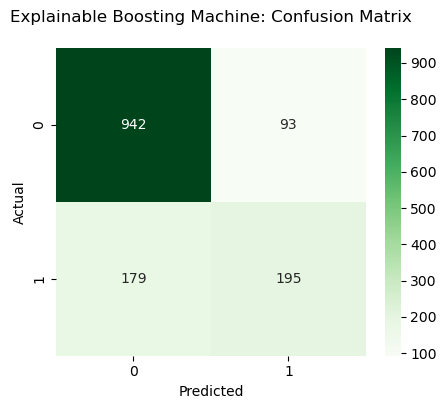

In [ ]:
#serve predictions
ebm_y_predict = ebm_best_model.predict(X_test)

#evaluate best model with confusion matrix plot
ebm_confusion = confusion_matrix(y_test, ebm_y_predict)

plt.figure(figsize=(5,4))
sns.heatmap(ebm_confusion, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Explainable Boosting Machine: Confusion Matrix\n')
plt.show()

In [ ]:
# Evaluate performance metrics
ebm_precision = precision_score(y_test, ebm_y_predict, pos_label=1)
ebm_recall = recall_score(y_test, ebm_y_predict, pos_label=1)
ebm_f1 = f1_score(y_test, ebm_y_predict, pos_label=1)

print(f'Explainable Boosting Machine model yielded {round(ebm_accuracy * 1e2, 1)}% accuracy.\nThis is the proportion of correctly predicted churn cases out of all cases.')
print(f'\nThe precision score is {round(ebm_precision * 1e2, 1)}%. This is the proportion of churn cases that are actually customers who churned.')
print(f'\nThe recall score is {round(ebm_recall * 1e2, 1)}%. This is the proportion of churn cases correctly predicted as customers who churned.')
print(f'\nThe f1-score is {round(ebm_f1 * 1e2, 1)}%. This is the balance between the precision \nand recall scores.')

Explainable Boosting Machine model yielded 80.7% accuracy.
This is the proportion of correctly predicted churn cases out of all cases.

The precision score is 67.7%. This is the proportion of churn cases that are actually customers who churned.

The recall score is 52.1%. This is the proportion of churn cases correctly predicted as customers who churned.

The f1-score is 58.9%. This is the balance between the precision 
and recall scores.


In [ ]:
#get prediction prababilities for positive class
ebm_y_predict_proba = ebm_best_model.predict_proba(X_test)[:, 1]

#return AUC score for the Explainable Boosting ROC curve
ebm_auc = roc_auc_score(y_test, ebm_y_predict_proba)
print(f'AUC score for Explainable Boosting model: {round(ebm_auc*1e2, 1)}%')

AUC score for Explainable Boosting model: 84.9%


# Selecting Best Model for Deployment

The models that were trained were Linear Regression, a Random Forest, Catboost and an Explainable Boosting Machine. The model that achieves the highest recall, F1-score and AUC will suit business impact and will be selected.
Business Impact is reduce churn rate because it is much less expensive to retain existing customers than to acquire new customers

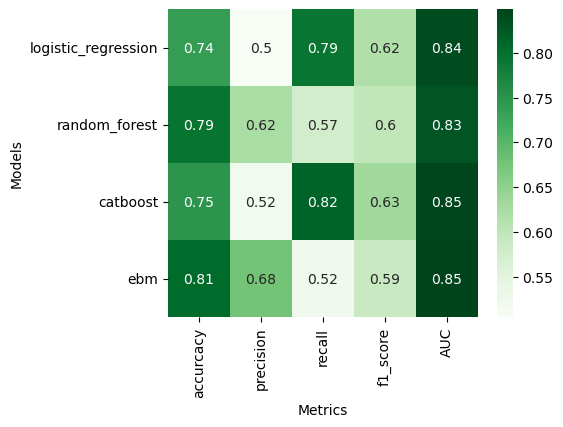

In [ ]:
#make metrics dataframe
metrics_df = pd.DataFrame({'accurcacy': [reg_accuracy, rf_accuracy, cat_accuracy, ebm_accuracy],
                           'precision': [reg_precision, rf_precision, cat_precision, ebm_precision],
                           'recall': [reg_recall, rf_recall, cat_recall, ebm_recall],
                           'f1_score': [reg_f1, rf_f1, cat_f1, ebm_f1],
                           'AUC': [reg_auc, rf_auc, cat_auc, ebm_auc]},
                         index=['logistic_regression', 'random_forest', 'catboost', 'ebm'])

#visualize model performance
plt.figure(figsize=(5,4))
sns.heatmap(metrics_df, annot=True, cmap='Greens')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.show()

From the visualization, Catboost is the model that beats the baseline model, and achieves the highest metrics of interest.
Catboost will be the selected model to deploy

### Plot Catboost Precision-Recall curve

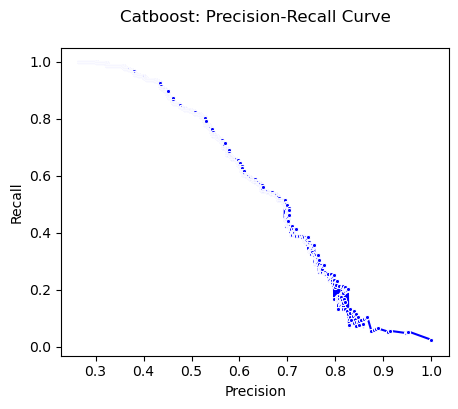

In [ ]:
# plot precision-recall curve
cat_precisions, cat_recalls, _ = precision_recall_curve(y_test, cat_y_predict_proba)

precisions_recalls_df = pd.DataFrame({'Precision': cat_precisions, 'Recall': cat_recalls})

plt.figure(figsize=(5, 4))
sns.lineplot(x='Precision', y='Recall', data=precisions_recalls_df, marker='.',  color='blue')

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Catboost: Precision-Recall Curve\n')
plt.show()

The precision-recall curve for the Catboost model is quite shifted to the upper-right corner. Indicating the model did perform well


# Explaining Catboost model with SHAP

Shap will be used to explain how the catboot model made predictions on whether a customer churned.

In [73]:
#get shap values
explainer = shap.TreeExplainer(cat_best_model)
train_shap_vals = explainer.shap_values(X_train)
test_shap_vals = explainer.shap_values(X_test)

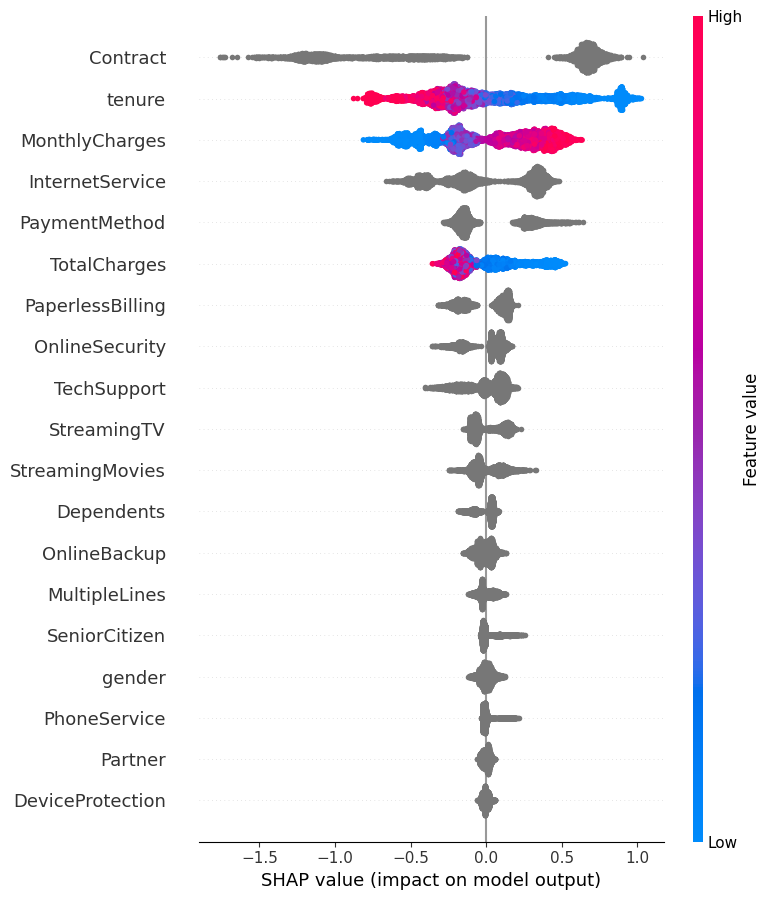

In [74]:
#visualize feature importances with beeswarm plot
#plt.figure(figsize=(5, 4))
shap.summary_plot(train_shap_vals, X_train, plot_type='dot')

This beeswarm plot shows how important each feature was during churn prediction using the Catboost model. Features with wider range of shap values contributed the most to churn prediction.

From the plot the five most important features that contributed to  predicting churn using the Catboost model are Contract, Tenure, Monthly Charges, Internet Service and Payment Method

<Figure size 500x400 with 0 Axes>

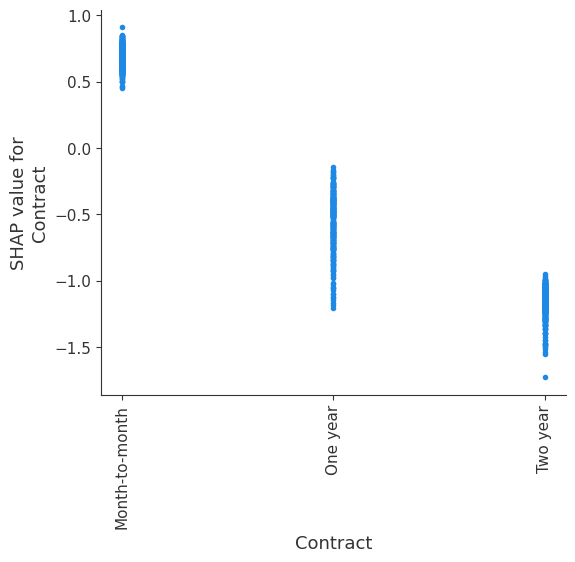

The Contract type that contributed most to churn prediction is month-to-month.


In [75]:
# dependence plot for Contract
plt.figure(figsize=(5, 4))
shap.dependence_plot('Contract', test_shap_vals, X_test, interaction_index=None)

print('The Contract type that contributed most to churn prediction is month-to-month.')

<Figure size 500x400 with 0 Axes>

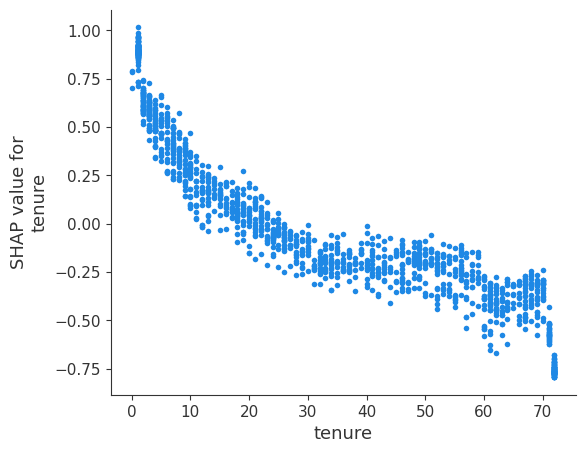

Tenure values increase as shap values decrease.
This indicates smaller tenure values contributed to churn predictions.


In [76]:
# dependence plot for Tenure
plt.figure(figsize=(5, 4))
shap.dependence_plot('tenure', test_shap_vals, X_test, interaction_index=None)

print('Tenure values increase as shap values decrease.\nThis indicates smaller tenure values contributed to churn predictions.')

<Figure size 500x400 with 0 Axes>

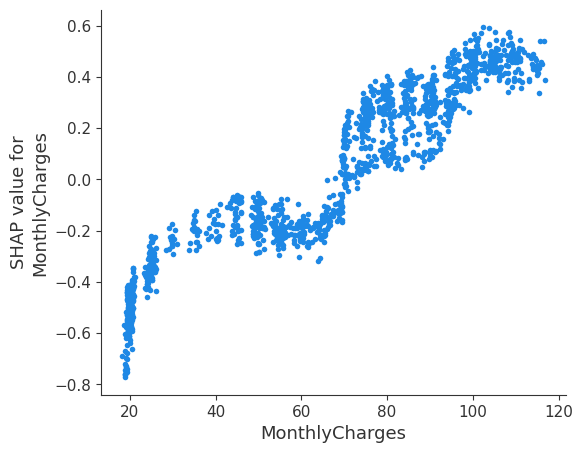

Monthly charges increase with shap values.
This indicates higher monthly charges contributed to churn predictions.


In [77]:
# dependence plot for MonthlyCharges
plt.figure(figsize=(5, 4))
shap.dependence_plot('MonthlyCharges', test_shap_vals, X_test, interaction_index=None)

print('Monthly charges increase with shap values.\nThis indicates higher monthly charges contributed to churn predictions.')

<Figure size 500x400 with 0 Axes>

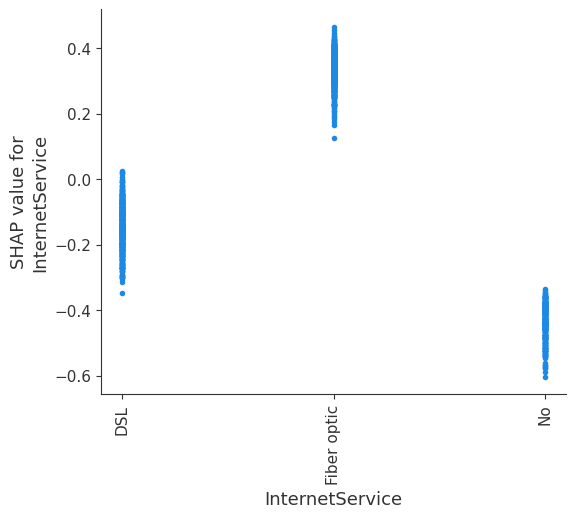

The Internet Service type that contributed most to churn prediction is fibre optic.


In [78]:
# dependence plot for Internet Service
plt.figure(figsize=(5, 4))
shap.dependence_plot('InternetService', test_shap_vals, X_test, interaction_index=None)

print('The Internet Service type that contributed most to churn prediction is fibre optic.')

<Figure size 500x400 with 0 Axes>

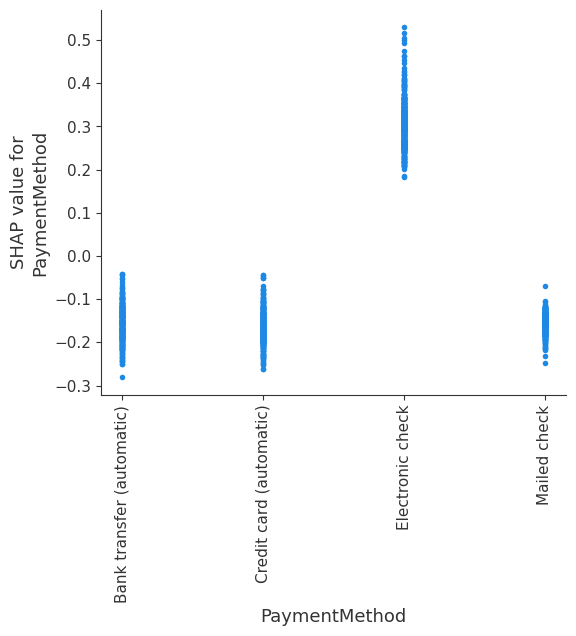

The Payment Method type that contributed most to churn prediction is electronic check.


In [79]:
# dependence plot for PaymentMethod
plt.figure(figsize=(5, 4))
shap.dependence_plot('PaymentMethod', test_shap_vals, X_test, interaction_index=None)

print('The Payment Method type that contributed most to churn prediction is electronic check.')

### Comparing model predictions with the ground truth

Check model prediction on customer 15:

In [86]:
#return output that checks model's prediction against true label
print('***'*12)
print(f'Ground truth label: {y_test[14]}\n')
print(f'Model prediction:  {cat_y_predict[14]}')
print('***'*12 )
print()

#force plot for specified customer
shap.initjs()
shap.force_plot(explainer.expected_value,
                test_shap_vals[14],
                X_test.iloc[14],
                figsize=(5,4),
                link='logit')

************************************
Ground truth label: 0

Model prediction:  0
************************************



In [11]:
#Save the best Catboost model
joblib.dump(cat_best_model, './catboost_model.pkl')

['./catboost_model.pkl']